<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/niko_code/red_data_analysis_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Data Analysis (strain, vbm and cbm, transition metals)

In [ ]:
!pip3 install pymatgen
!pip install mp_api

In [ ]:
# Import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
from pymatgen.core.structure import Structure
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
import time

## Importing all data

In [ ]:
# Load the JSON data
with open("materials_data.json") as f:
    materials_data = json.load(f)

In [ ]:
start = time.time()

# Build tabular dataset
records = []
for m in materials_data:
    struct = Structure.from_dict(m["structure"])
    elements = struct.species

    # electronegativity
    en_values = [Element(el).X for el in elements]
    min_en_values = np.min(en_values)
    max_en_values = np.max(en_values)

    #ie
    ie_values = [Element(el).ionization_energy for el in elements]
    min_ie_values = np.min(ie_values)
    max_ie_values = np.max(ie_values)

    #am
    am_values = [Element(el).atomic_mass for el in elements]
    min_am_values = np.min(am_values)
    max_am_values = np.max(am_values)

    #vdw
    vdw_values = [Element(el).van_der_waals_radius for el in elements]
    min_vdw_values = np.min(vdw_values)
    max_vdw_values = np.max(vdw_values)

    record = {
        "material_id": m["material_id"],
        "band_gap": m["band_gap"],
        "formula": m["formula_pretty"],
        "density": m["density"],
        "volume": m["volume"],
        "a": struct.lattice.a,
        "b": struct.lattice.b,
        "c": struct.lattice.c,
        "alpha": struct.lattice.alpha,
        "beta": struct.lattice.beta,
        "gamma": struct.lattice.gamma,
        "n_atoms": m["nsites"],

        #"electronegativities": en_data,
        "avg_en": np.mean(en_values),
        "en_range": max_en_values - min_en_values,
        "max_en": max_en_values,
        "min_en": min_en_values,
        "std_en": np.std(en_values),

        "avg_ie": np.mean(ie_values),
        "ie_range": max_ie_values - min_ie_values,
        "max_ie": max_ie_values,
        "min_ie": min_ie_values,
        "std_ie": np.std(ie_values),

        "avg_am": np.mean(am_values),
        "en_range": max_am_values - min_am_values,
        "max_am": max_am_values,
        "min_am": min_am_values,
        "std_am": np.std(am_values),

        "avg_vdw": np.mean(vdw_values),
        "vdw_range": max_vdw_values - min_vdw_values,
        "max_vdw": max_vdw_values,
        "min_vdw": min_vdw_values,
        "std_vdw": np.std(vdw_values),

        # Other values
        "vbm": m["vbm"],
        "cbm": m["cbm"],
        "bulk_modulus": m["bulk_modulus"],
        "shear_modulus": m["shear_modulus"],
        "elements": m["elements"],
    }
    records.append(record)

end = time.time()

print(f"Execution time: {end - start:.4f} seconds")

# df = pd.DataFrame(records)
# df.to_csv("bandgap_dataset.csv", index=False)

# print(f"Saved tabular dataset to bandgap_dataset.csv with shape {df.shape}")

/var/folders/3h/0n37yt9x4ln_3_2vddm8dppm0000gn/T/ipykernel_77525/1314586660.py:10: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  en_values = [Element(el).X for el in elements]
/var/folders/3h/0n37yt9x4ln_3_2vddm8dppm0000gn/T/ipykernel_77525/1314586660.py:10: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  en_values = [Element(el).X for el in elements]
/var/folders/3h/0n37yt9x4ln_3_2vddm8dppm0000gn/T/ipykernel_77525/1314586660.py:10: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  en_values = [Element(el).X for el in elements]


Execution time: 123.7840 seconds


In [ ]:
df_main = pd.DataFrame(records)

# make a copy of dataframe
df_main_initial = df_main.copy()

In [ ]:
# Step 1: Keep relevant columns and drop rows with missing shear modulus
shear_df = df_main[["material_id", "shear_modulus"]].dropna()

# Step 2: Expand the dictionary in 'shear_modulus' into separate columns
shear_components = shear_df["shear_modulus"].apply(pd.Series)

# Step 3: Rename the columns
shear_components.rename(columns={
    "voigt": "s_voigt",
    "reuss": "s_reuss",
    "vrh": "s_vrh"
}, inplace=True)

# Step 4: Combine with 'material_id'
shear_df_final = pd.concat([shear_df["material_id"], shear_components], axis=1)

# do the same for bulk modulus
bulk_df = df_main[["material_id", "bulk_modulus"]].dropna()

# Step 2: Expand the dictionary in 'bulk_modulus' into separate columns
bulk_components = bulk_df["bulk_modulus"].apply(pd.Series)

# Step 3: Rename the columns
bulk_components.rename(columns={
    "voigt": "b_voigt",
    "reuss": "b_reuss",
    "vrh": "b_vrh"
}, inplace=True)

# Step 4: Combine with 'material_id'
bulk_df_final = pd.concat([bulk_df["material_id"], bulk_components], axis=1)

# merge the two dataframes to the original dataframe
df = df_main.merge(shear_df_final, on="material_id", how="left")
df = df_main.merge(bulk_df_final, on="material_id", how="left")

# drop the original columns
df_main = df_main.drop(columns=["shear_modulus", "bulk_modulus"])

## Acquiring Data From .json file

In [ ]:
# Load the JSON data
with open("materials_data.json") as f:
    materials_data = json.load(f)

In [ ]:
# 'builder_meta', 'nsites', 'elements', 'nelements',\
#                    'composition', 'composition_reduced', 'formula_pretty',\
#                    'formula_anonymous', 'chemsys', 'volume', 'density',\
#                    'density_atomic', 'symmetry', 'property_name', 'material_id',\
#                    'deprecated', 'deprecation_reasons', 'last_updated', 'origins',\
#                    'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom',\
#                    'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull',\
#                    'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to',\
#                    'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi',\
#                    'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure',\
#                    'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering',\
#                    'total_magnetization', 'total_magnetization_normalized_vol',\
#                    'total_magnetization_normalized_formula_units', 'num_magnetic_sites',\
#                    'num_unique_magnetic_sites', 'types_of_magnetic_species', 'bulk_modulus',\
#                    'shear_modulus', 'universal_anisotropy', 'homogeneous_poisson',\
#                    'e_total', 'e_ionic', 'e_electronic', 'n', 'e_ij_max',\
#                    'weighted_surface_energy_EV_PER_ANG2', 'weighted_surface_energy',\
#                    'weighted_work_function', 'surface_anisotropy', 'shape_factor',\
#                    'has_reconstructed', 'possible_species', 'has_props',\
#                    'theoretical', 'database_IDs']

In [ ]:
# Build a tabular dataset that contains strain, band gap values, and element values
records = []
for m in materials_data:
    struct = Structure.from_dict(m["structure"])
    record = {
        "material_id": m["material_id"],
        "band_gap": m["band_gap"],
        "bulk_modulus": m.get("bulk_modulus", None), # Insert None if the there are no values
        "shear_modulus": m.get("shear_modulus", None),
        "elements": m["elements"],
        "vbm": m["vbm"],
        "cbm": m["cbm"],
    }
    records.append(record)

df = pd.DataFrame(records)

### Data analysis

Notice that only 3906 values for shear and bulk values are present. Also, there are fewer vbm and cbm values than the total number.

In [ ]:
# make a copy of dataframe
df_initial = df.copy()

In [ ]:
print(df_initial.shape)
df_initial.info()
df_initial.describe()

(82998, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82998 entries, 0 to 82997
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   material_id    82998 non-null  object 
 1   band_gap       82998 non-null  float64
 2   bulk_modulus   3906 non-null   object 
 3   shear_modulus  3906 non-null   object 
 4   elements       82998 non-null  object 
 5   vbm            82122 non-null  float64
 6   cbm            82122 non-null  float64
dtypes: float64(3), object(4)
memory usage: 4.4+ MB


,band_gap,vbm,cbm
count,82998.000000,82122.000000,82122.000000
mean,1.984421,1.585835,3.591381
std,1.560981,2.238984,2.214685
min,0.000000,-14.222600,-7.360600
25%,0.653400,0.166850,2.368150
50%,1.728450,1.629350,3.660450
75%,3.013225,2.952475,4.974900
max,17.891400,12.376100,14.341400


#### Clean the data so that only float values apear

In [ ]:
df = df_initial.copy()
a = df["shear_modulus"].dropna()
print(a[0])

{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}


In [ ]:
# Step 1: Keep relevant columns and drop rows with missing shear modulus
shear_df = df[["material_id", "shear_modulus"]].dropna()

# Step 2: Expand the dictionary in 'shear_modulus' into separate columns
shear_components = shear_df["shear_modulus"].apply(pd.Series)

# Step 3: Rename the columns
shear_components.rename(columns={
    "voigt": "s_voigt",
    "reuss": "s_reuss",
    "vrh": "s_vrh"
}, inplace=True)

# Step 4: Combine with 'material_id'
shear_df_final = pd.concat([shear_df["material_id"], shear_components], axis=1)

# do the same for bulk modulus
bulk_df = df[["material_id", "bulk_modulus"]].dropna()

# Step 2: Expand the dictionary in 'bulk_modulus' into separate columns
bulk_components = bulk_df["bulk_modulus"].apply(pd.Series)

# Step 3: Rename the columns
bulk_components.rename(columns={
    "voigt": "b_voigt",
    "reuss": "b_reuss",
    "vrh": "b_vrh"
}, inplace=True)

# Step 4: Combine with 'material_id'
bulk_df_final = pd.concat([bulk_df["material_id"], bulk_components], axis=1)

# merge the two dataframes to the original dataframe
df = df.merge(shear_df_final, on="material_id", how="left")
df = df.merge(bulk_df_final, on="material_id", how="left")

# drop the original columns
df = df.drop(columns=["shear_modulus", "bulk_modulus"])

In [ ]:
print(df.shape)
df.info()
df.describe()

(82998, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82998 entries, 0 to 82997
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   material_id  82998 non-null  object 
 1   band_gap     82998 non-null  float64
 2   elements     82998 non-null  object 
 3   vbm          82122 non-null  float64
 4   cbm          82122 non-null  float64
 5   s_voigt      3906 non-null   float64
 6   s_reuss      3906 non-null   float64
 7   s_vrh        3906 non-null   float64
 8   b_voigt      3906 non-null   float64
 9   b_reuss      3906 non-null   float64
 10  b_vrh        3906 non-null   float64
dtypes: float64(9), object(2)
memory usage: 7.0+ MB


,band_gap,vbm,cbm,s_voigt,s_reuss,s_vrh,b_voigt,b_reuss,b_vrh
count,82998.000000,82122.000000,82122.000000,3.906000e+03,3906.000000,3.906000e+03,3.906000e+03,3906.000000,3.906000e+03
mean,1.984421,1.585835,3.591381,-1.168219e+09,34.525918,-5.841097e+08,1.186600e+04,55.945211,5.960971e+03
std,1.560981,2.238984,2.214685,7.301140e+10,100.558324,3.650570e+10,6.992562e+05,1123.636490,3.496958e+05
min,0.000000,-14.222600,-7.360600,-4.563066e+12,-4410.673000,-2.281533e+12,-2.256240e+06,-69299.120000,-1.128047e+06
25%,0.653400,0.166850,2.368150,1.337850e+01,8.292500,1.105525e+01,2.612075e+01,21.147250,2.343600e+01
50%,1.728450,1.629350,3.660450,2.904100e+01,22.793000,2.573100e+01,5.554650e+01,50.648500,5.323400e+01
75%,3.013225,2.952475,4.974900,5.618525e+01,49.121500,5.245875e+01,1.107737e+02,104.806000,1.075623e+02
max,17.891400,12.376100,14.341400,3.178049e+06,1374.466000,1.589075e+06,4.331111e+07,8436.677000,2.165977e+07


### Corelation Matrix

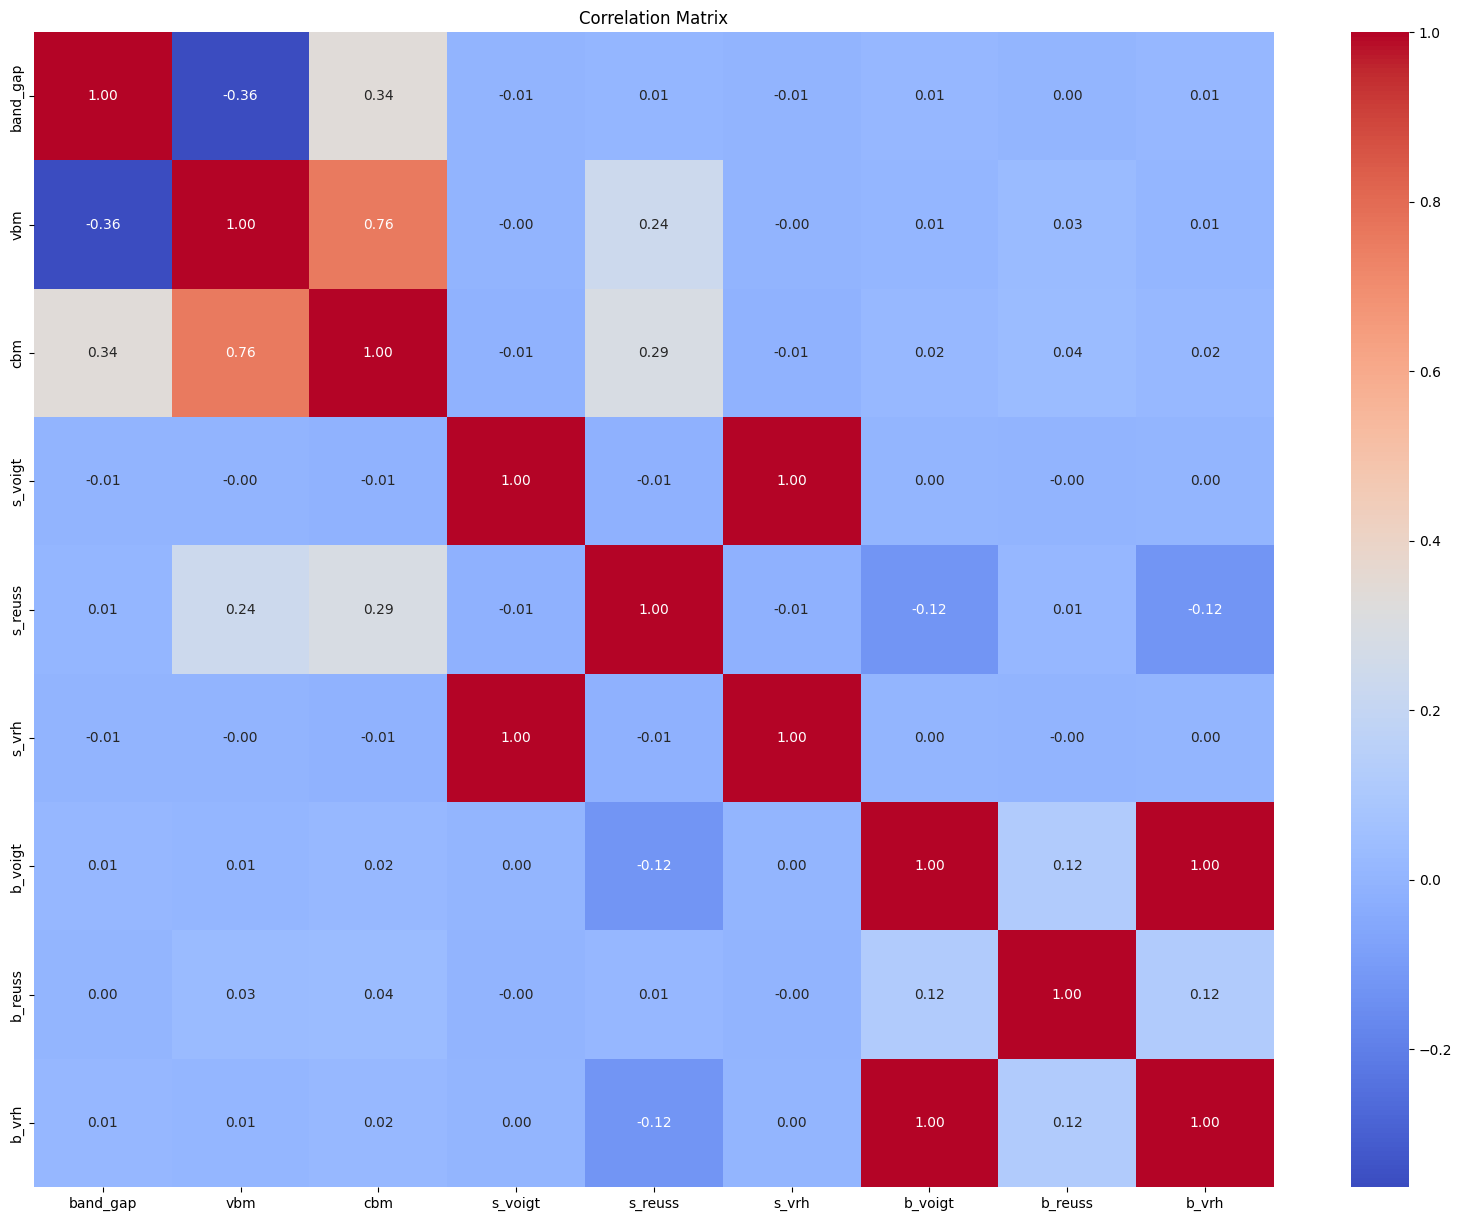

82998

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()
len(df)

Notice that we have red checkered squares, this is due to vrh calculating the average of reuss and voigt. Voigt is a large value and reuss is a small value, so that the average is dominated by voigt.

In [ ]:
# show all the shear values
print("Reuss shear modulus values:")
print(df[df["s_reuss"].notnull()]["s_reuss"].head(5))

print("Voigt shear modulus values:")
print(df[df["s_voigt"].notnull()]["s_voigt"].head(5))

print("VRH shear modulus values:")
print(df[df["s_vrh"].notnull()]["s_vrh"].head(5))

Reuss shear modulus values:
0     28.813
6     12.163
8     14.204
9     28.832
12    20.479
Name: s_reuss, dtype: float64
Voigt shear modulus values:
0     42.704
6     13.420
8     15.399
9     32.007
12    47.959
Name: s_voigt, dtype: float64
VRH shear modulus values:
0     35.758
6     12.791
8     14.801
9     30.419
12    34.219
Name: s_vrh, dtype: float64


In [ ]:
print(df.shape)
df.info()
df.describe()

(82998, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82998 entries, 0 to 82997
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   material_id  82998 non-null  object 
 1   band_gap     82998 non-null  float64
 2   elements     82998 non-null  object 
 3   vbm          82122 non-null  float64
 4   cbm          82122 non-null  float64
 5   s_voigt      3906 non-null   float64
 6   s_reuss      3906 non-null   float64
 7   s_vrh        3906 non-null   float64
 8   b_voigt      3906 non-null   float64
 9   b_reuss      3906 non-null   float64
 10  b_vrh        3906 non-null   float64
dtypes: float64(9), object(2)
memory usage: 7.0+ MB


,band_gap,vbm,cbm,s_voigt,s_reuss,s_vrh,b_voigt,b_reuss,b_vrh
count,82998.000000,82122.000000,82122.000000,3.906000e+03,3906.000000,3.906000e+03,3.906000e+03,3906.000000,3.906000e+03
mean,1.984421,1.585835,3.591381,-1.168219e+09,34.525918,-5.841097e+08,1.186600e+04,55.945211,5.960971e+03
std,1.560981,2.238984,2.214685,7.301140e+10,100.558324,3.650570e+10,6.992562e+05,1123.636490,3.496958e+05
min,0.000000,-14.222600,-7.360600,-4.563066e+12,-4410.673000,-2.281533e+12,-2.256240e+06,-69299.120000,-1.128047e+06
25%,0.653400,0.166850,2.368150,1.337850e+01,8.292500,1.105525e+01,2.612075e+01,21.147250,2.343600e+01
50%,1.728450,1.629350,3.660450,2.904100e+01,22.793000,2.573100e+01,5.554650e+01,50.648500,5.323400e+01
75%,3.013225,2.952475,4.974900,5.618525e+01,49.121500,5.245875e+01,1.107737e+02,104.806000,1.075623e+02
max,17.891400,12.376100,14.341400,3.178049e+06,1374.466000,1.589075e+06,4.331111e+07,8436.677000,2.165977e+07


### Missing Data Analysis

In [ ]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
print(missing_df[missing_df['Missing Values'] > 0])

         Missing Values    Percent
vbm                 876   1.055447
cbm                 876   1.055447
s_voigt           79092  95.293863
s_reuss           79092  95.293863
s_vrh             79092  95.293863
b_voigt           79092  95.293863
b_reuss           79092  95.293863
b_vrh             79092  95.293863


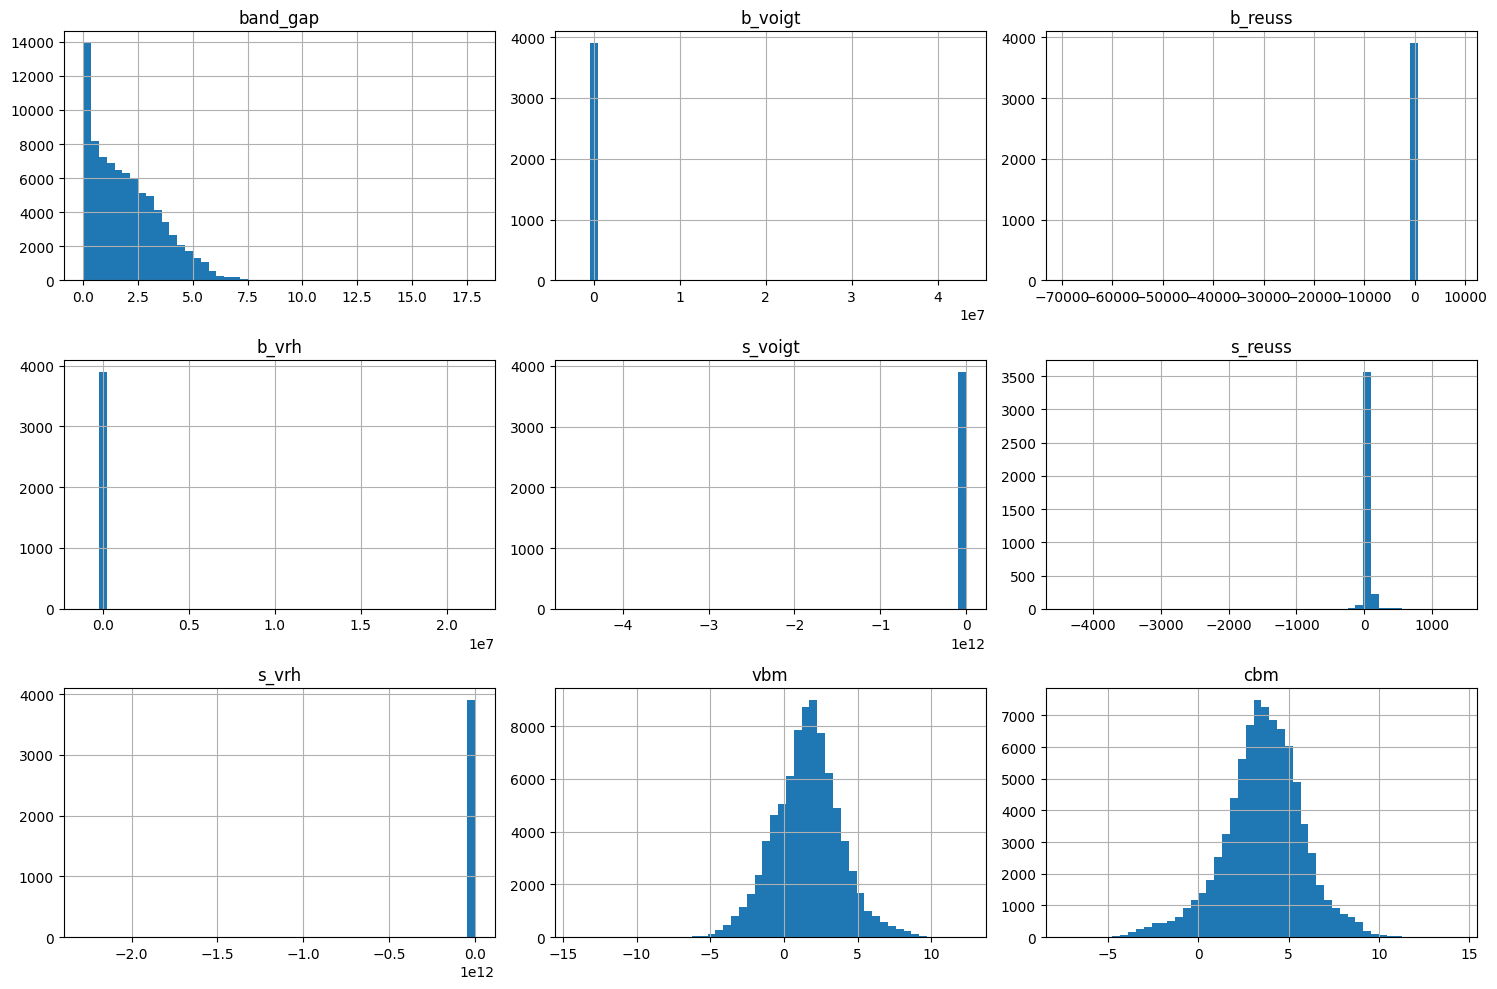

In [ ]:
numeric_features = ["band_gap", "b_voigt", "b_reuss", "b_vrh", "s_voigt", "s_reuss", "s_vrh", "vbm", "cbm"]
df[numeric_features].hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

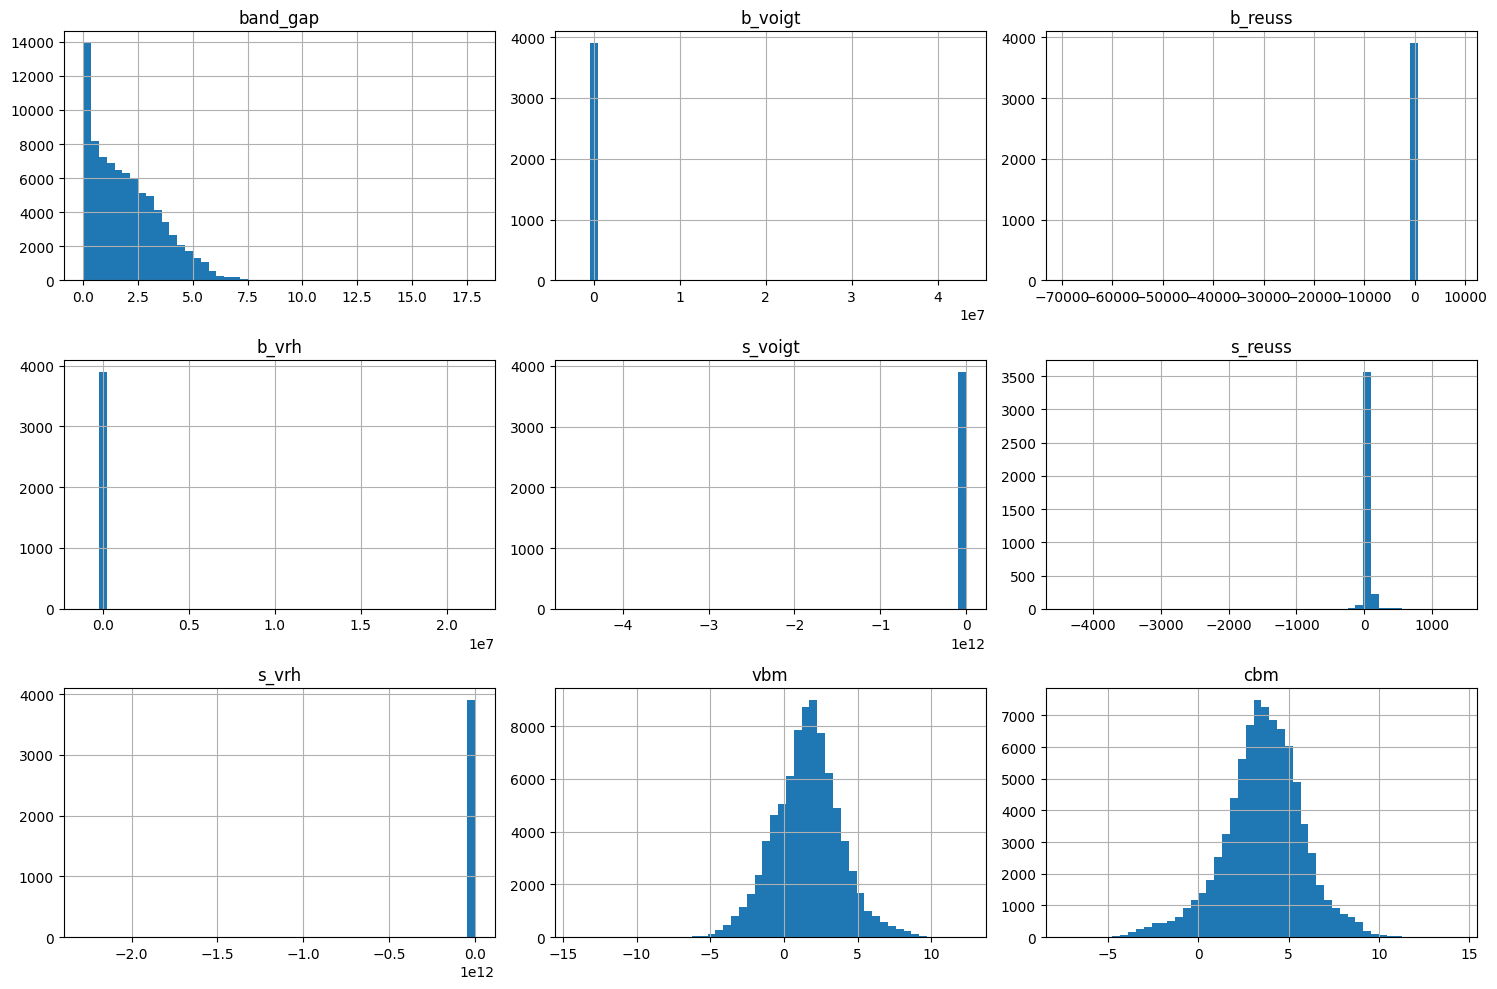

In [ ]:
numeric_features = ["band_gap", "b_voigt", "b_reuss", "b_vrh", "s_voigt", "s_reuss", "s_vrh", "vbm", "cbm"]
df[numeric_features].hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [ ]:
# numeric_features = ["band_gap", "b_voigt", "b_reuss", "b_vrh", "s_voigt", "s_reuss", "s_vrh"]]
# df[numeric_features].hist(bins=50, figsize=(15, 10))
# plt.tight_layout()
# plt.show()

## Strain Analysis

Notice that only 3906 values are present for bulk and shear moduli. Some values are outliers.

<Figure size 1200x800 with 0 Axes>

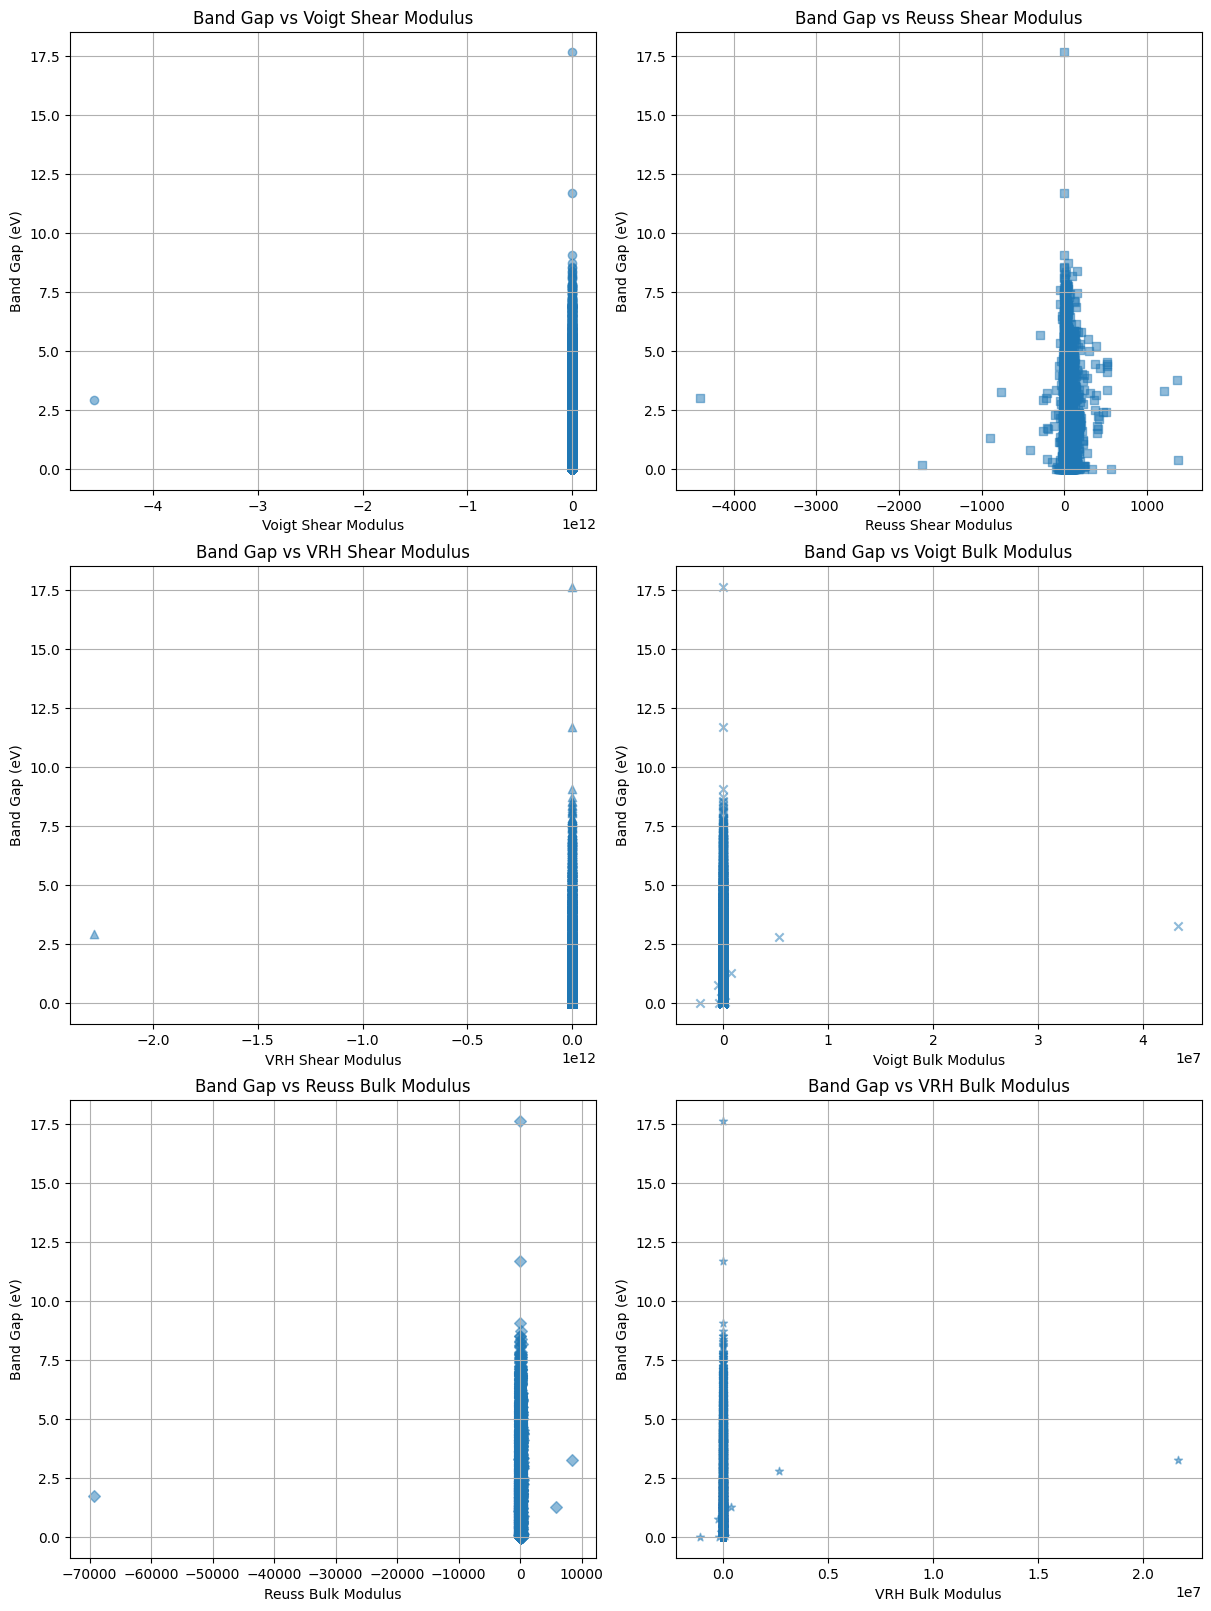

In [ ]:
plt.figure(figsize=(12, 8))

# Create subplots for each pair of Band Gap vs Modulus
fig, axes = plt.subplots(3, 2, figsize=(12, 16), constrained_layout=True)

# Plot Band Gap vs Voigt Shear Modulus
axes[0, 0].scatter(df["s_voigt"], df["band_gap"], alpha=0.5, label="Voigt Shear Modulus", marker='o')
axes[0, 0].set_xlabel("Voigt Shear Modulus")
axes[0, 0].set_ylabel("Band Gap (eV)")
axes[0, 0].set_title("Band Gap vs Voigt Shear Modulus")
axes[0, 0].grid()

# Plot Band Gap vs Reuss Shear Modulus
axes[0, 1].scatter(df["s_reuss"], df["band_gap"], alpha=0.5, label="Reuss Shear Modulus", marker='s')
axes[0, 1].set_xlabel("Reuss Shear Modulus")
axes[0, 1].set_ylabel("Band Gap (eV)")
axes[0, 1].set_title("Band Gap vs Reuss Shear Modulus")
axes[0, 1].grid()

# Plot Band Gap vs VRH Shear Modulus
axes[1, 0].scatter(df["s_vrh"], df["band_gap"], alpha=0.5, label="VRH Shear Modulus", marker='^')
axes[1, 0].set_xlabel("VRH Shear Modulus")
axes[1, 0].set_ylabel("Band Gap (eV)")
axes[1, 0].set_title("Band Gap vs VRH Shear Modulus")
axes[1, 0].grid()

# Plot Band Gap vs Voigt Bulk Modulus
axes[1, 1].scatter(df["b_voigt"], df["band_gap"], alpha=0.5, label="Voigt Bulk Modulus", marker='x')
axes[1, 1].set_xlabel("Voigt Bulk Modulus")
axes[1, 1].set_ylabel("Band Gap (eV)")
axes[1, 1].set_title("Band Gap vs Voigt Bulk Modulus")
axes[1, 1].grid()

# Plot Band Gap vs Reuss Bulk Modulus
axes[2, 0].scatter(df["b_reuss"], df["band_gap"], alpha=0.5, label="Reuss Bulk Modulus", marker='D')
axes[2, 0].set_xlabel("Reuss Bulk Modulus")
axes[2, 0].set_ylabel("Band Gap (eV)")
axes[2, 0].set_title("Band Gap vs Reuss Bulk Modulus")
axes[2, 0].grid()

# Plot Band Gap vs VRH Bulk Modulus
axes[2, 1].scatter(df["b_vrh"], df["band_gap"], alpha=0.5, label="VRH Bulk Modulus", marker='*')
axes[2, 1].set_xlabel("VRH Bulk Modulus")
axes[2, 1].set_ylabel("Band Gap (eV)")
axes[2, 1].set_title("Band Gap vs VRH Bulk Modulus")
axes[2, 1].grid()

plt.show()

<Figure size 1200x800 with 0 Axes>

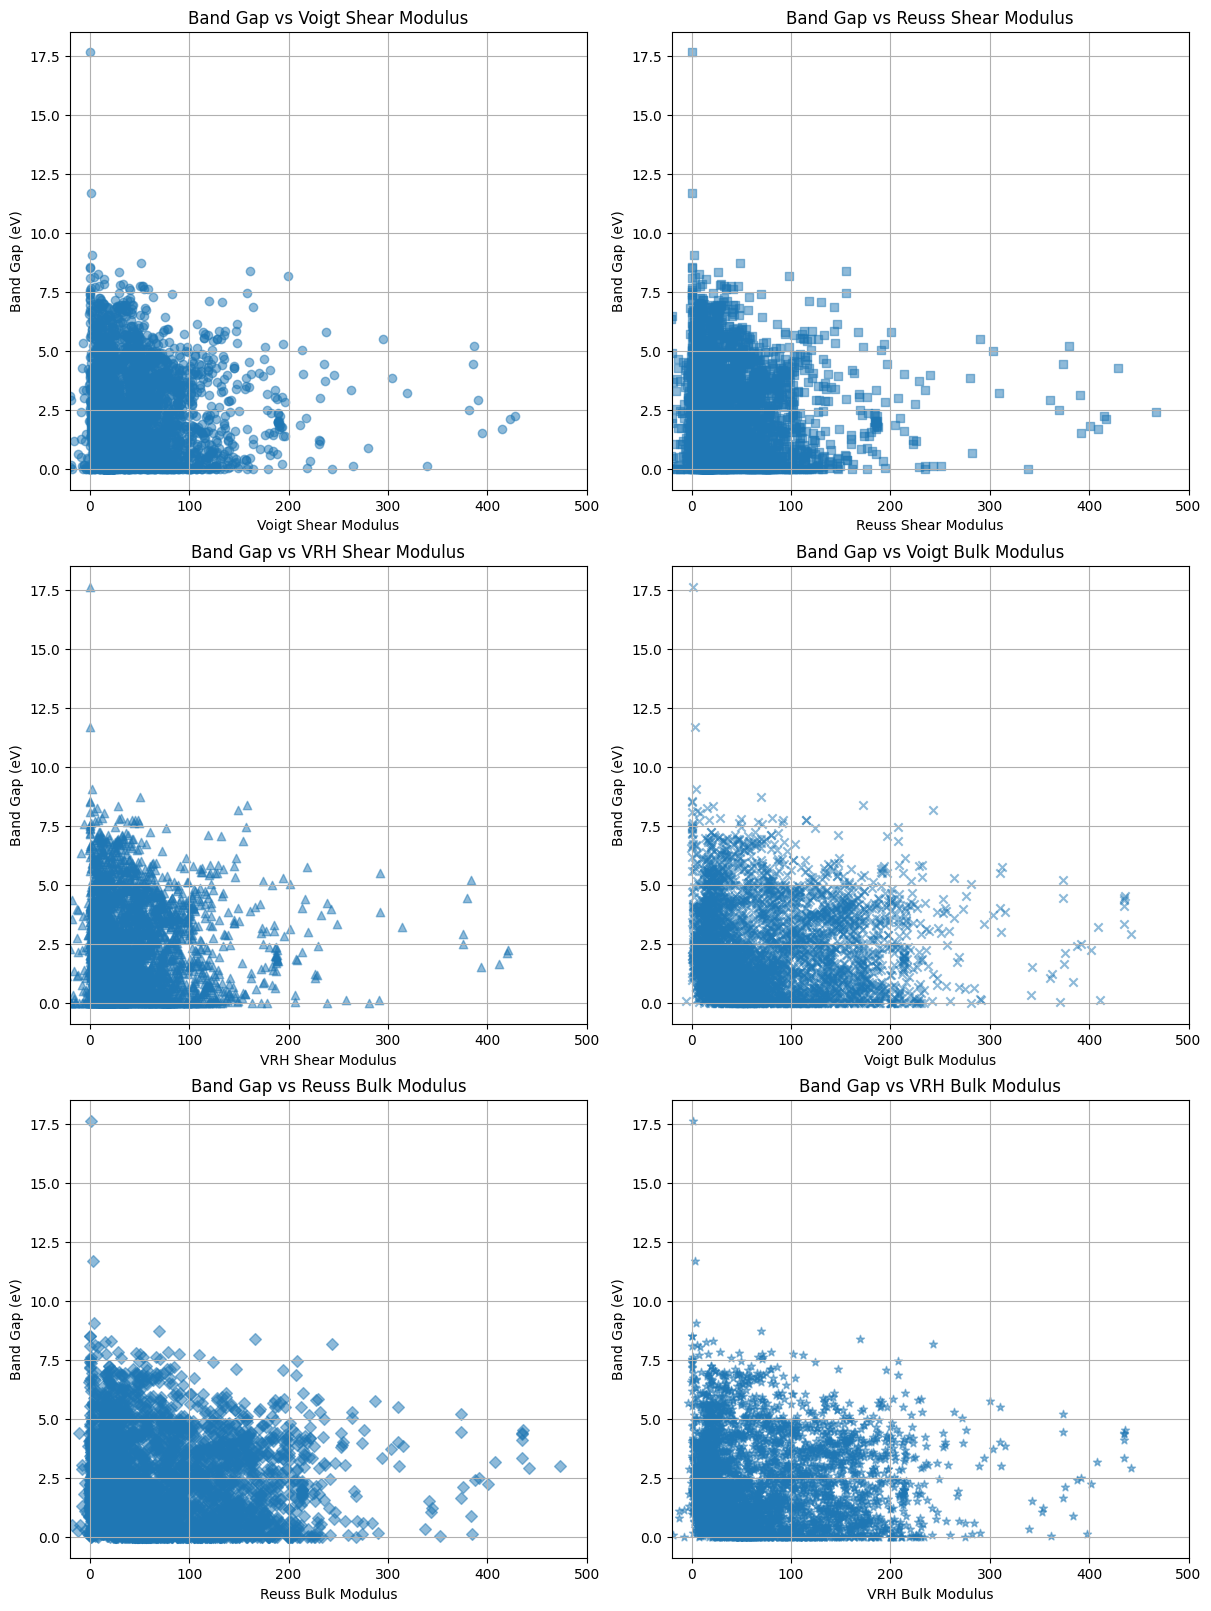

In [ ]:
plt.figure(figsize=(12, 8))

# Create subplots for each pair of Band Gap vs Modulus
fig, axes = plt.subplots(3, 2, figsize=(12, 16), constrained_layout=True)

# Plot Band Gap vs Voigt Shear Modulus
axes[0, 0].scatter(df["s_voigt"], df["band_gap"], alpha=0.5, label="Voigt Shear Modulus", marker='o')
axes[0, 0].set_xlabel("Voigt Shear Modulus")
axes[0, 0].set_ylabel("Band Gap (eV)")
axes[0, 0].set_title("Band Gap vs Voigt Shear Modulus")
axes[0, 0].set_xlim(-20, 500)
axes[0, 0].grid()

# Plot Band Gap vs Reuss Shear Modulus
axes[0, 1].scatter(df["s_reuss"], df["band_gap"], alpha=0.5, label="Reuss Shear Modulus", marker='s')
axes[0, 1].set_xlabel("Reuss Shear Modulus")
axes[0, 1].set_ylabel("Band Gap (eV)")
axes[0, 1].set_title("Band Gap vs Reuss Shear Modulus")
axes[0, 1].set_xlim(-20, 500)
axes[0, 1].grid()

# Plot Band Gap vs VRH Shear Modulus
axes[1, 0].scatter(df["s_vrh"], df["band_gap"], alpha=0.5, label="VRH Shear Modulus", marker='^')
axes[1, 0].set_xlabel("VRH Shear Modulus")
axes[1, 0].set_ylabel("Band Gap (eV)")
axes[1, 0].set_title("Band Gap vs VRH Shear Modulus")
axes[1, 0].set_xlim(-20, 500)
axes[1, 0].grid()

# Plot Band Gap vs Voigt Bulk Modulus
axes[1, 1].scatter(df["b_voigt"], df["band_gap"], alpha=0.5, label="Voigt Bulk Modulus", marker='x')
axes[1, 1].set_xlabel("Voigt Bulk Modulus")
axes[1, 1].set_ylabel("Band Gap (eV)")
axes[1, 1].set_title("Band Gap vs Voigt Bulk Modulus")
axes[1, 1].set_xlim(-20, 500)
axes[1, 1].grid()

# Plot Band Gap vs Reuss Bulk Modulus
axes[2, 0].scatter(df["b_reuss"], df["band_gap"], alpha=0.5, label="Reuss Bulk Modulus", marker='D')
axes[2, 0].set_xlabel("Reuss Bulk Modulus")
axes[2, 0].set_ylabel("Band Gap (eV)")
axes[2, 0].set_title("Band Gap vs Reuss Bulk Modulus")
axes[2, 0].set_xlim(-20, 500)
axes[2, 0].grid()

# Plot Band Gap vs VRH Bulk Modulus
axes[2, 1].scatter(df["b_vrh"], df["band_gap"], alpha=0.5, label="VRH Bulk Modulus", marker='*')
axes[2, 1].set_xlabel("VRH Bulk Modulus")
axes[2, 1].set_ylabel("Band Gap (eV)")
axes[2, 1].set_title("Band Gap vs VRH Bulk Modulus")
axes[2, 1].set_xlim(-20, 500)
axes[2, 1].grid()

plt.show()

## Looking at vbm and cbm

<Figure size 1200x800 with 0 Axes>

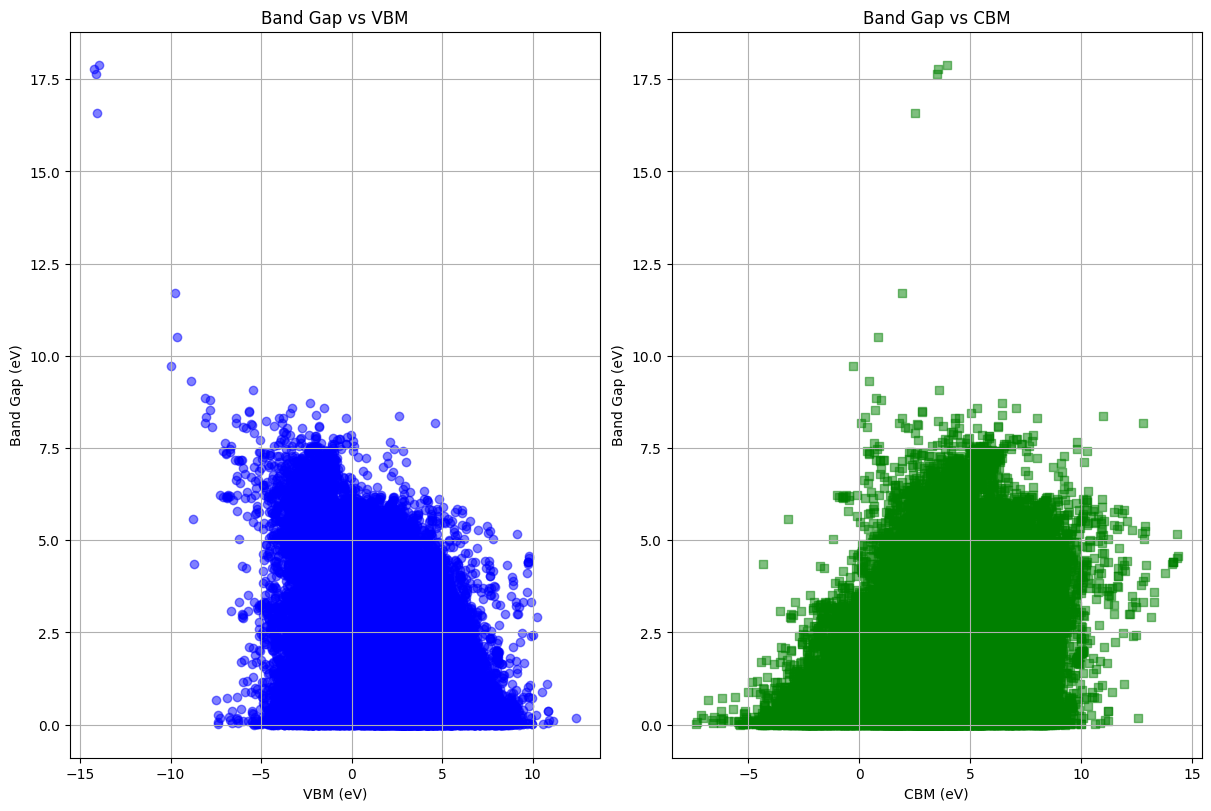

In [ ]:
plt.figure(figsize=(12, 8))

# Create subplots for each pair of Band Gap vs VBM/CBM
fig, axes = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)

# Plot Band Gap vs VBM
axes[0].scatter(df["vbm"], df["band_gap"], alpha=0.5, label="VBM", marker='o', color='blue')
axes[0].set_xlabel("VBM (eV)")
axes[0].set_ylabel("Band Gap (eV)")
axes[0].set_title("Band Gap vs VBM")
axes[0].grid()

# Plot Band Gap vs CBM
axes[1].scatter(df["cbm"], df["band_gap"], alpha=0.5, label="CBM", marker='s', color='green')
axes[1].set_xlabel("CBM (eV)")
axes[1].set_ylabel("Band Gap (eV)")
axes[1].set_title("Band Gap vs CBM")
axes[1].grid()

plt.show()


## Get Transition Metals

In [ ]:
from mp_api.client import MPRester
from pymatgen.core.periodic_table import Element

# Define all transition metals (periodic table blocks d-block, periods 4–7)
transition_metals = [el.symbol for el in Element if el.is_transition_metal]
transition_metals_set = set(transition_metals)
print(transition_metals)


['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Ac', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn']
False


In [ ]:
tm_oxides = [
    doc for doc in df.itertuples()
    if "O" in [str(e) for e in doc.elements] and transition_metals_set.intersection(str(e) for e in doc.elements)
]
print("Number of TM oxides:", len(tm_oxides))

Number of TM oxides: 43473


In [ ]:
print("Sample TM oxides:")
for doc in tm_oxides[:5]:
    print(f"Material ID: {doc.material_id}, Elements: {doc.elements}, Band Gap: {doc.band_gap}")

Sample TM oxides:
Material ID: mp-11107, Elements: ['Ac', 'O'], Band Gap: 3.522599999999999
Material ID: mp-1183115, Elements: ['Ac', 'Al', 'O'], Band Gap: 4.1024
Material ID: mp-1183052, Elements: ['Ac', 'B', 'O'], Band Gap: 0.8071
Material ID: mp-30274, Elements: ['Ac', 'Br', 'O'], Band Gap: 4.241
Material ID: mp-30273, Elements: ['Ac', 'Cl', 'O'], Band Gap: 4.4451


In [ ]:
tm_oxides_df = pd.DataFrame(tm_oxides)
print(tm_oxides_df.shape)
print(tm_oxides_df.info())
print(tm_oxides_df.describe())

(43473, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43473 entries, 0 to 43472
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Index        43473 non-null  int64  
 1   material_id  43473 non-null  object 
 2   band_gap     43473 non-null  float64
 3   elements     43473 non-null  object 
 4   vbm          43292 non-null  float64
 5   cbm          43292 non-null  float64
 6   s_voigt      642 non-null    float64
 7   s_reuss      642 non-null    float64
 8   s_vrh        642 non-null    float64
 9   b_voigt      642 non-null    float64
 10  b_reuss      642 non-null    float64
 11  b_vrh        642 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 4.0+ MB
None
              Index      band_gap           vbm           cbm       s_voigt  \
count  43473.000000  43473.000000  43292.000000  43292.000000  6.420000e+02   
mean   43020.837692      1.736965      1.932125      3.676333  5.0

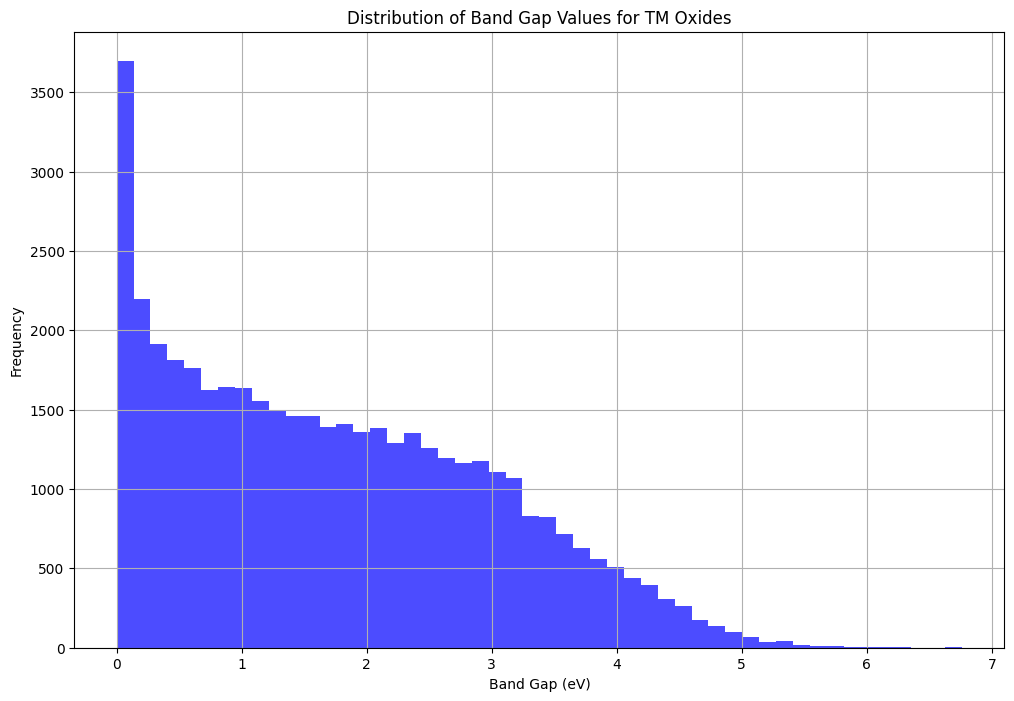

In [ ]:
# make a plot of the band gap values
plt.figure(figsize=(12, 8))
plt.hist(tm_oxides_df["band_gap"].dropna(), bins=50, alpha=0.7, color='blue')
plt.xlabel("Band Gap (eV)")
plt.ylabel("Frequency")
plt.title("Distribution of Band Gap Values for TM Oxides")
plt.grid()
plt.show()

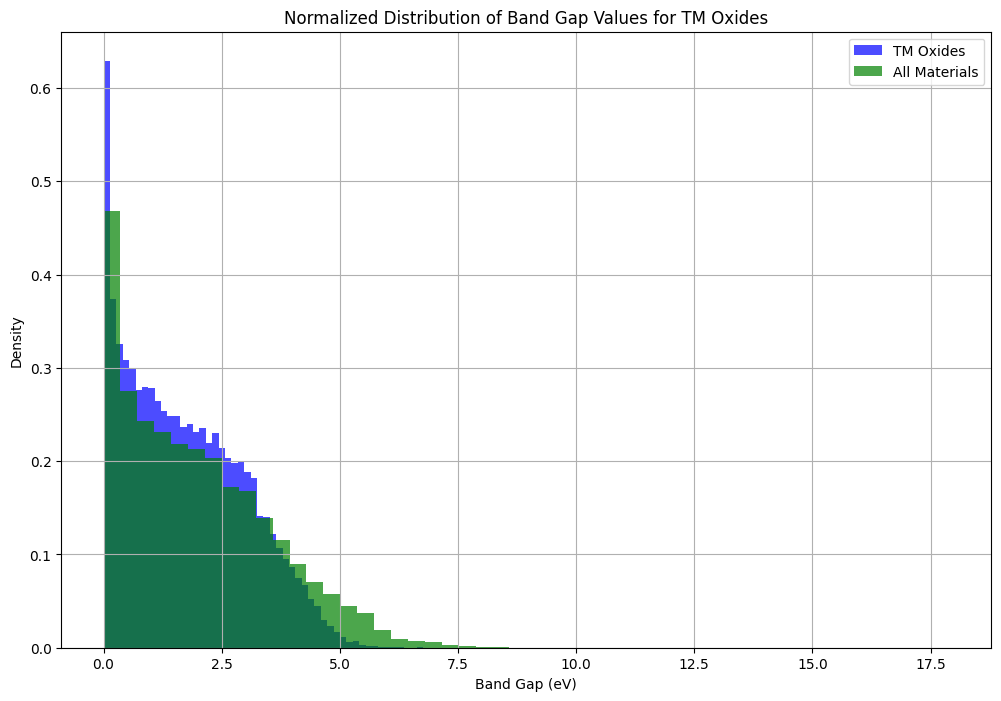

In [ ]:
# make a plot of the band gap values
plt.figure(figsize=(12, 8))
plt.hist(tm_oxides_df["band_gap"].dropna(), bins=50, alpha=0.7, color='blue', density=True, label="TM Oxides")
plt.hist(df_main["band_gap"].dropna(), bins=50, alpha=0.7, color='green', density=True, label="All Materials")
plt.xlabel("Band Gap (eV)")
plt.ylabel("Density")
plt.title("Normalized Distribution of Band Gap Values for TM Oxides")
plt.grid()
plt.legend()
plt.show()

## Look at all the features only for transition metal oxides

In [ ]:
tm_oxides_main = [
    doc for doc in df_main.itertuples()
    if "O" in [str(e) for e in doc.elements] and transition_metals_set.intersection(str(e) for e in doc.elements)
]
print("Number of TM oxides:", len(tm_oxides))

Number of TM oxides: 43473


In [ ]:
# Extract the relevant data

In [ ]:
tm_oxides_df_main = pd.DataFrame(tm_oxides_main)
print(tm_oxides_df.shape)
print(tm_oxides_df.info())

(43473, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43473 entries, 0 to 43472
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          43473 non-null  int64  
 1   material_id    43473 non-null  object 
 2   band_gap       43473 non-null  float64
 3   formula        43473 non-null  object 
 4   density        43473 non-null  float64
 5   volume         43473 non-null  float64
 6   a              43473 non-null  float64
 7   b              43473 non-null  float64
 8   c              43473 non-null  float64
 9   alpha          43473 non-null  float64
 10  beta           43473 non-null  float64
 11  gamma          43473 non-null  float64
 12  n_atoms        43473 non-null  int64  
 13  avg_en         43473 non-null  float64
 14  en_range       43473 non-null  float64
 15  max_en         43473 non-null  float64
 16  min_en         43473 non-null  float64
 17  std_en         43473 non-null  float64

In [ ]:
tm_oxides_df_main.head(5)

,Index,material_id,band_gap,formula,density,volume,a,b,c,alpha,...,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,elements
0,0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.0,...,15.9994,103.368761,1.900000,0.95,2.47,1.52,0.465403,4.5896,8.1122,"[Ac, O]"
1,4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.0,...,15.9994,83.410543,1.774000,0.95,2.47,1.52,0.369410,6.8036,10.9060,"[Ac, Al, O]"
2,5,mp-1183052,0.8071,AcBO3,9.206879,51.548126,3.721668,3.721668,3.721668,90.0,...,10.8110,84.942852,1.790000,0.95,2.47,1.52,0.373631,6.8964,7.7035,"[Ac, B, O]"
3,7,mp-30274,4.2410,AcBrO,7.652290,140.139410,4.310370,4.310370,7.542774,90.0,...,15.9994,88.344203,1.946667,0.95,2.47,1.52,0.393813,3.2008,7.4418,"[Ac, Br, O]"
4,9,mp-30273,4.4451,AcClO,7.156871,129.213203,4.259225,4.259225,7.122716,90.0,...,15.9994,95.213181,1.913333,0.95,2.47,1.52,0.404667,3.5334,7.9785,"[Ac, Cl, O]"


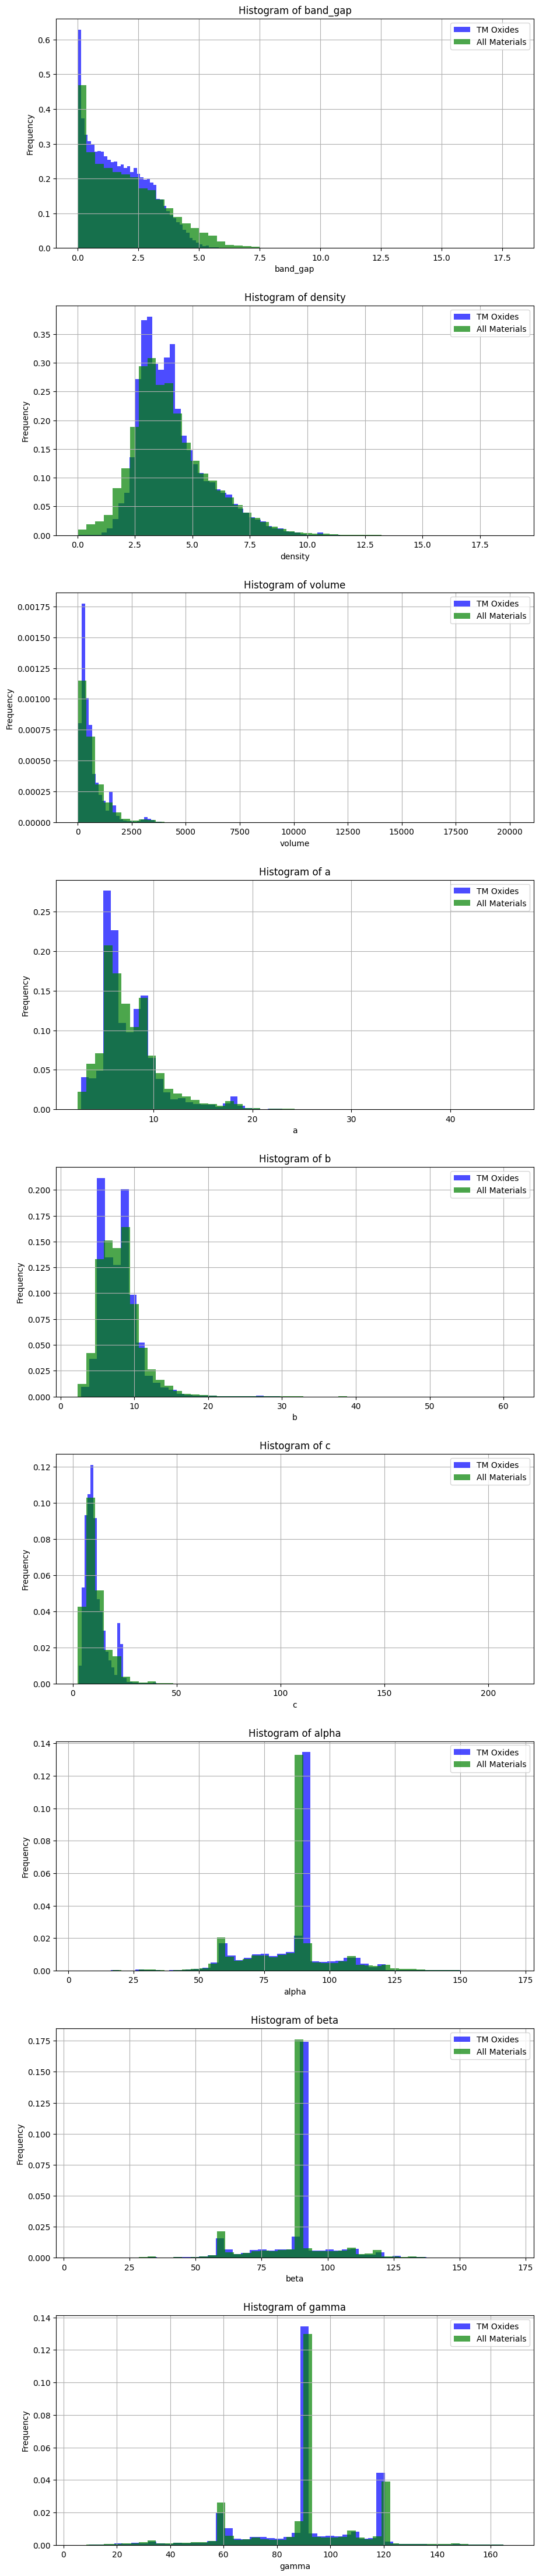

In [ ]:
numeric_features = ["band_gap", "density", "volume", "a", "b", "c", "alpha", "beta", "gamma"]
# Create subplots for each feature
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(10, 5 * len(numeric_features)))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(numeric_features):
   # Plot histogram for tm_oxides_df_main
   axes[i].hist(tm_oxides_df_main[feature].dropna(), bins=50, alpha=0.7, color='blue', label='TM Oxides', density=True)
   # Plot histogram for df_main
   axes[i].hist(df_main[feature].dropna(), bins=50, alpha=0.7, color='green', label='All Materials', density=True)
   axes[i].set_title(f"Histogram of {feature}")
   axes[i].set_xlabel(feature)
   axes[i].set_ylabel("Frequency")
   axes[i].grid()
   axes[i].legend()

plt.show()


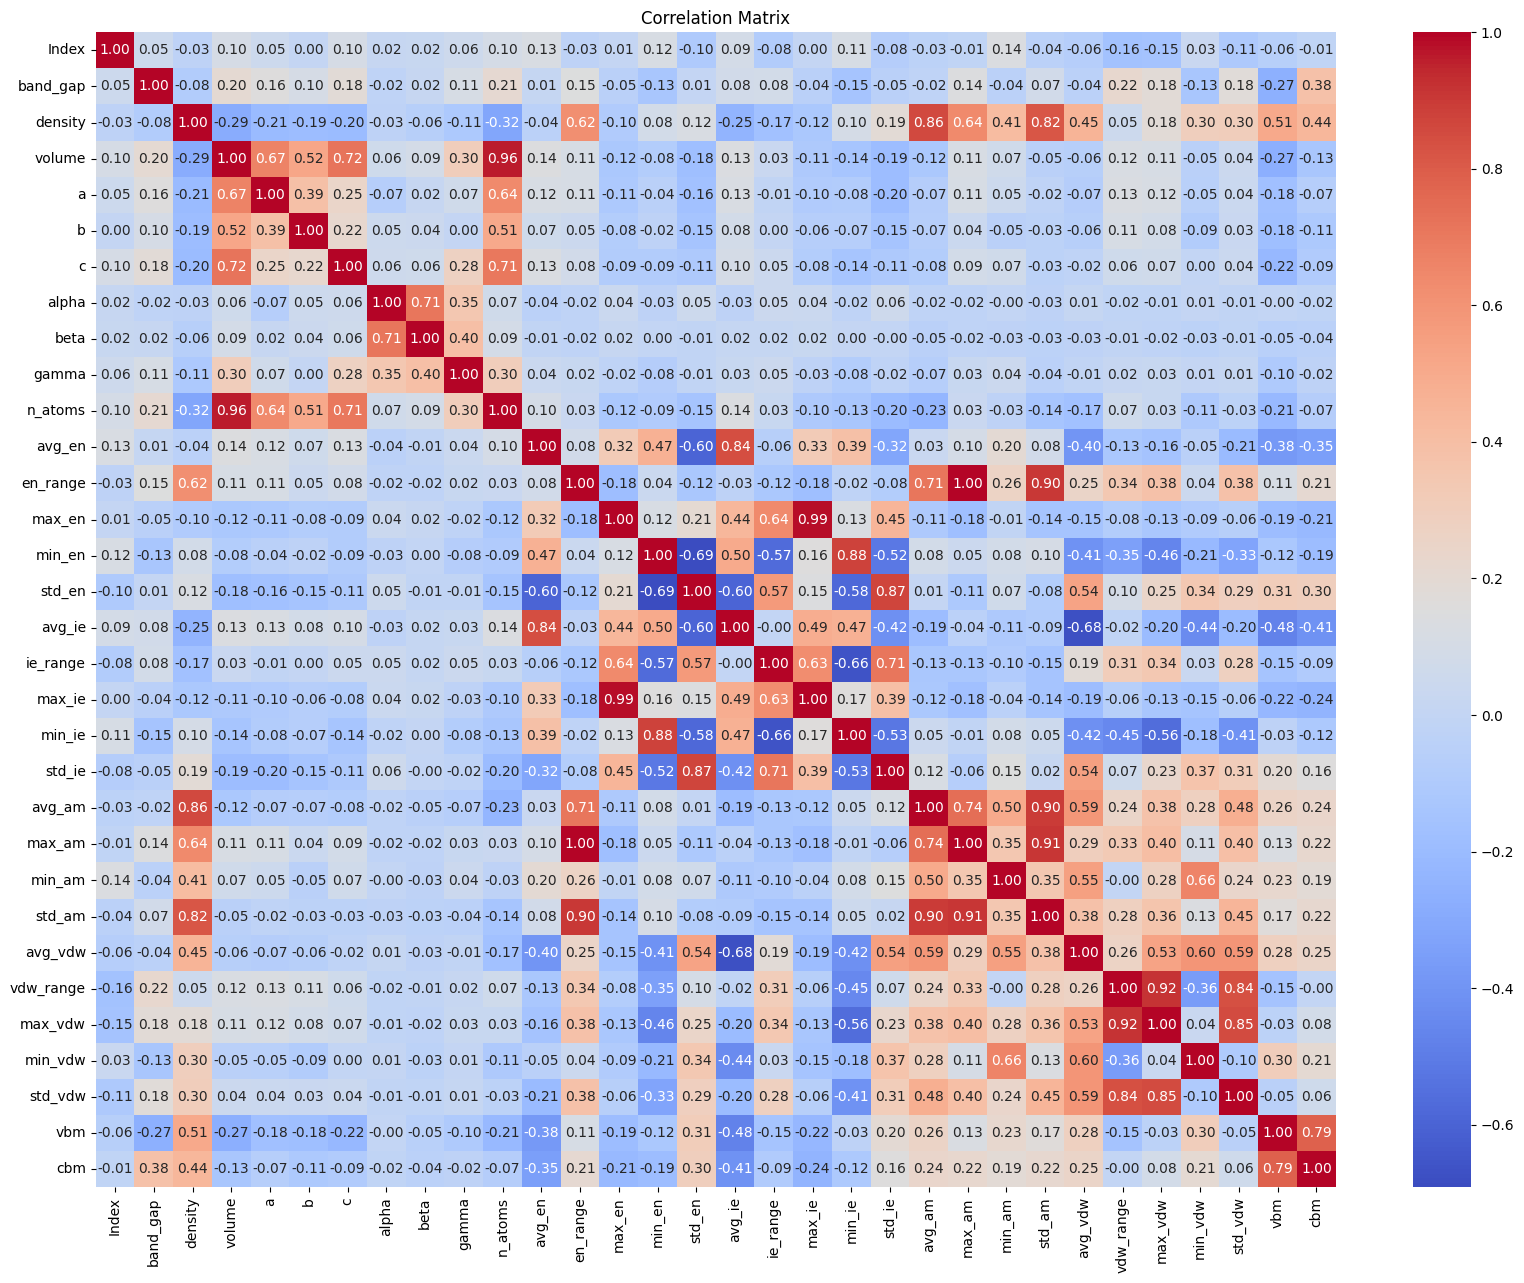

82998

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(tm_oxides_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()
len(df)